# Plot analysis results

ssh notes:
```
ssh -L localhost:8889:localhost:8889 shakebot@10.155.10.212
jupyter notebook --no-browser --port=8889
```

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pprint

## Find npy files

In [2]:
def find_npy_files(folder):
    npy_files = []
    
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.endswith('.npy'):
                npy_files.append(os.path.join(root, file))
    
    return npy_files

In [3]:
current_path = os.getcwd()
parent_path = os.path.abspath(os.path.join(current_path, os.pardir, os.pardir))
data_path = os.path.join(parent_path, 'data')
print(data_path)

/root/rsisa/data


In [4]:
npy_files = find_npy_files(data_path)
npy_files = [f for f in npy_files if "twins" not in f]
print(len(npy_files))

947


## Performance analysis 

In [5]:
p_npy_files = [f for f in npy_files if "split_shp_tif" not in f]
p_npy_files = [f for f in p_npy_files if "results.npy" in f]
p_npy_files = [f for f in p_npy_files if "random_generation_" in f]

"""
for i in range(10):
    print("random_generation_"+str(i))
    p_npy_files_ = [f for f in p_npy_files if "random_generation_"+str(i) in f]
    print(len(p_npy_files_))
"""

performance_dict = {}
for f in p_npy_files:
    data = np.load(f)
    exp = f.split('/')[-2]
    if not performance_dict.get(exp, False):
        performance_dict[exp]=[data]
    else:
        performance_dict[exp].append(data)

In [6]:
mean_dict = {}
std_dict = {}

for key in performance_dict:
    data = np.asarray(performance_dict[key])
    mean_dict[key] = data.mean(axis=0)
    std_dict[key] = data.std(axis=0)
    
pprint.pprint(mean_dict)
print('*'*40)
pprint.pprint(std_dict)

{'ellipses_100_1000_5_100000_1000_50000_200000': array([99.36743448, 98.78161177, 99.63744781]),
 'ellipses_200_1000_5_100000_1000_50000_200000': array([98.61769436, 97.43025485, 99.07887767]),
 'ellipses_30_1000_20_100000_1000_50000_200000': array([99.76743455, 99.57888901, 99.87446749]),
 'ellipses_30_1000_40_100000_1000_50000_200000': array([99.73408763, 99.5489165 , 99.83373575]),
 'ellipses_30_1000_5_100000_1000_100000_200000': array([99.30647004, 98.91163913, 99.55295092]),
 'ellipses_30_1000_5_100000_1000_20000_200000': array([99.83992879, 99.74860582, 99.82517874]),
 'ellipses_30_1000_5_100000_1000_50000_200000': array([99.77345709, 99.6451166 , 99.80613375]),
 'ellipses_30_1000_5_100000_1000_50000_400000': array([96.98563487, 95.49668472, 98.92816658]),
 'ellipses_30_1000_5_100000_1000_50000_800000': array([75.9675901 , 73.23799641, 92.36953141]),
 'ellipses_30_1000_5_100000_2000_50000_200000': array([99.77327993, 99.49392753, 99.93197279]),
 'ellipses_30_1000_5_100000_500_500

## Algorithm analysis of annotation splitting

In [7]:
as_npy_files = [f for f in npy_files if "split_shp_tif" in f]
as_npy_files = [f for f in as_npy_files if "time_complexity_M_" in f]

as_time_list = []
as_space_list = []
for f in as_npy_files:
    data = np.load(f)
    as_time_list.append(data[0])
    as_space_list.append(data[1])

In [8]:
t_min = np.min([t.shape[0] for t in as_time_list])

as_time_array = []
for t in as_time_list:
    as_time_array.append(t[:t_min])
as_time_array = np.asarray(as_time_array)
as_time_mean = as_time_array.mean(axis=0)
as_time_std = as_time_array.std(axis=0)

as_space_array = []
for s in as_space_list:
    as_space_array.append(s[:t_min])
as_space_array = np.asarray(as_space_array)
as_space_mean = as_space_array.mean(axis=0)
as_space_std = as_space_array.std(axis=0)

In [9]:
from matplotlib.image import imread
from tempfile import NamedTemporaryFile

def get_size(fig, dpi=100):
    with NamedTemporaryFile(suffix='.png') as f:
        fig.savefig(f.name, bbox_inches='tight', dpi=dpi)
        height, width, _channels = imread(f.name).shape
        return width / dpi, height / dpi

def set_size(fig, size, dpi=100, eps=1e-2, give_up=2, min_size_px=10):
    target_width, target_height = size
    set_width, set_height = target_width, target_height # reasonable starting point
    deltas = [] # how far we have
    while True:
        fig.set_size_inches([set_width, set_height])
        actual_width, actual_height = get_size(fig, dpi=dpi)
        set_width *= target_width / actual_width
        set_height *= target_height / actual_height
        deltas.append(abs(actual_width - target_width) + abs(actual_height - target_height))
        if deltas[-1] < eps:
            return True
        if len(deltas) > give_up and sorted(deltas[-give_up:]) == deltas[-give_up:]:
            return False
        if set_width * dpi < min_size_px or set_height * dpi < min_size_px:
            return False

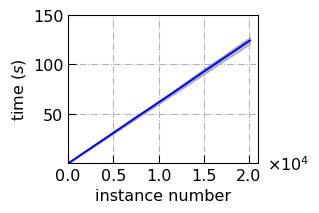

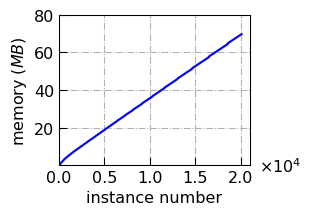

In [10]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams.update({'font.size': 12})

size = (2.8, 2.0)
dpi = 96

fig = plt.figure(figsize = size, dpi=dpi)
plt.plot(range(t_min), as_time_mean, color='blue')
plt.fill_between(range(t_min), as_time_mean + as_time_std, as_time_mean - as_time_std, color='gray', alpha=0.5, label='std')
set_size(fig, size, dpi=dpi)
#plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.gca().xaxis.get_offset_text().set_visible(False)
plt.text(220000, 0, r'$\times 10^5$', va='center')
plt.xticks(np.arange(0, 210000, 50000))
plt.yticks(np.arange(50, 160, 50))
plt.tick_params(direction="in", length=6)
plt.xlabel("instance number")
plt.ylabel("time ($s$)")
plt.xlim(0, 210000)
plt.ylim(0, 150)
plt.grid(linestyle='-.')
plt.savefig('../../docs/annotation_split_time.svg', format='svg')
plt.show()

size = (2.7, 2.02)
dpi = 96

fig = plt.figure(figsize = size, dpi=dpi)
plt.plot(range(t_min), as_space_mean, color='blue')
plt.fill_between(range(t_min), as_space_mean + as_space_std, as_space_mean - as_space_std, color='gray', alpha=0.5, label='std')
set_size(fig, size, dpi=dpi)
#plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.gca().xaxis.get_offset_text().set_visible(False)
plt.text(220000, 0, r'$\times 10^5$', va='center')
plt.xticks(np.arange(0, 210000, 50000))
plt.yticks(np.arange(20, 81, 20))
plt.tick_params(direction="in", length=6)
plt.xlabel("instance number")
plt.ylabel("memory ($MB$)")
plt.xlim(0, 210000)
plt.ylim(0, 80)
plt.grid(linestyle='-.')
plt.savefig('../../docs/annotation_split_space.svg', format='svg')
plt.show()


## Algorithm analysis of instance registration

O(M)

In [11]:
irm_npy_files = [f for f in npy_files if "split_shp_tif" not in f]
irm_npy_files = [f for f in irm_npy_files if "time_complexity_M_" in f]
irm_npy_files = [f for f in irm_npy_files if "time_space" in f]

ir_time_list = []
ir_space_list = []
for f in irm_npy_files:
    data = np.load(f)
    ir_time_list.append(data[0])
    ir_space_list.append(data[1])

In [12]:
t_min = np.min([t.shape[0] for t in ir_time_list])

ir_time_array = []
for t in ir_time_list:
    ir_time_array.append(t[:t_min])
ir_time_array = np.asarray(ir_time_array)
ir_time_mean = ir_time_array.mean(axis=0)
ir_time_std = ir_time_array.std(axis=0)

ir_space_array = []
for s in ir_space_list:
    ir_space_array.append(s[:t_min])
ir_space_array = np.asarray(ir_space_array)
ir_space_mean = ir_space_array.mean(axis=0)
ir_space_std = ir_space_array.std(axis=0)

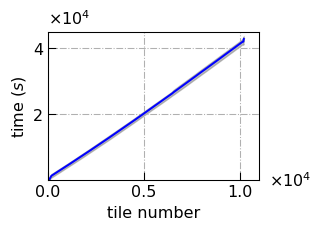

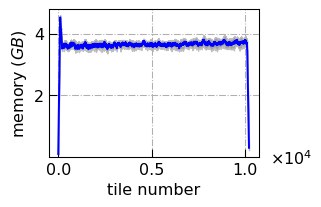

In [13]:
size = (3.14, 2.0)
dpi = 96

fig = plt.figure(figsize = size, dpi=dpi)
plt.plot(range(t_min), ir_time_mean, color='blue', label='Line')
plt.fill_between(range(t_min), ir_time_mean + ir_time_std, ir_time_mean - ir_time_std, color='gray', alpha=0.5, label='std')
set_size(fig, size, dpi=dpi)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.gca().yaxis.get_offset_text().set_visible(False)
plt.text(0, 49000, r'$\times 10^4$', va='center')
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.gca().xaxis.get_offset_text().set_visible(False)
plt.text(11500, 0, r'$\times 10^4$', va='center')
plt.xticks(np.arange(0, 12000, 5000))
plt.yticks(np.arange(20000, 50000, 20000))
plt.tick_params(direction="in", length=6)
plt.xlabel("tile number")
plt.ylabel("time ($s$)")
plt.xlim(0, 11000)
plt.ylim(0, 45000)
plt.grid(linestyle='-.')
plt.savefig('../../docs/instance_registration_tile_time.svg', format='svg')
plt.show()

size = (3.02, 2.0)
fig = plt.figure(figsize = size, dpi=dpi)
plt.plot(range(t_min), ir_space_mean, color='blue', label='Line')
plt.fill_between(range(t_min), ir_space_mean + ir_space_std, ir_space_mean - ir_space_std, color='gray', alpha=0.5, label='std')
set_size(fig, size, dpi=dpi)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.gca().xaxis.get_offset_text().set_visible(False)
plt.text(11300, 0, r'$\times 10^4$', va='center')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.gca().yaxis.get_offset_text().set_visible(False)
#plt.text(-1500, 5200, r'$\times 10^3$', va='center')
plt.xticks(np.arange(0, 12000, 5000))
plt.yticks(np.arange(2000, 4800, 2000))
plt.tick_params(direction="in", length=6)
plt.xlabel("tile number")
plt.ylabel("memory ($GB$)")
#plt.xlim(0, 11000)
plt.ylim(0, 4800)
plt.grid(linestyle='-.')
plt.savefig('../../docs/instance_registration_tile_space.svg', format='svg')
plt.show()

O(plog(p))

In [14]:
irp_npy_files = [f for f in npy_files if "split_shp_tif" not in f]
irp_npy_files = [f for f in irp_npy_files if "time_complexity_P_" in f]
irp_npy_files = [f for f in irp_npy_files if "time_space" in f]


time_dict = {}
space_dict = {}
for f in irp_npy_files:
    data = np.load(f)
    exp = f.split('/')[-1].split('.')[0].split('_')[-5]
    if not time_dict.get(exp, False):
        time_dict[exp]=[data[0]]
        space_dict[exp]=[data[1]]
    else:
        time_dict[exp].append(data[0])
        space_dict[exp].append(data[1])




In [15]:
t_min = 1e5
for key in time_dict:
    time_list = time_dict[key]
    t_min_ = np.min([t.shape[0] for t in time_list])
    if t_min_ < t_min:
        t_min = t_min_

p_list = []
t_mean_list = []
t_std_list = []
t_upper_list = []
t_lower_list = []
keys = list(time_dict.keys())
keys.sort()
for key in keys:
    p_list.append(int(key))
    t_list = time_dict[key]
    t_mean = np.asarray([t[:t_min] for t in t_list]).mean(axis=0)[-1]
    t_mean_list.append(t_mean)
    t_std = np.asarray([t[:t_min] for t in t_list]).std(axis=0)[-1]
    t_std_list.append(t_std)
    t_upper_list.append(t_mean + t_std)
    t_lower_list.append(t_mean - t_std)
    
    
p_list = []
s_mean_list = []
s_std_list = []
s_upper_list = []
s_lower_list = []
keys = list(space_dict.keys())
keys.sort()
for key in keys:
    p_list.append(int(key))
    s_list = space_dict[key]
    s_mean = np.asarray([s[:t_min] for s in s_list]).mean(axis=0).max()
    s_mean_list.append(s_mean)
    s_std = np.asarray([s[:t_min] for s in s_list]).std(axis=0).max()
    s_std_list.append(s_std)
    s_upper_list.append(s_mean + s_std)
    s_lower_list.append(s_mean - s_std)

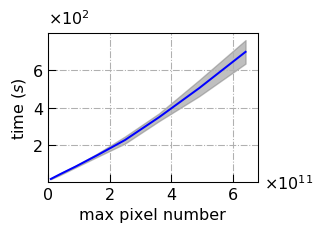

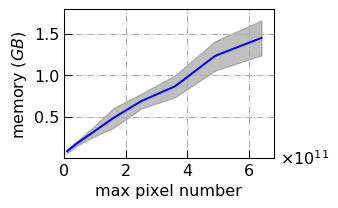

In [16]:
size = (2.8, 2.20)
dpi = 96
fig = plt.figure(figsize = size, dpi=dpi)
plt.plot([p**2 for p in p_list], t_mean_list, color='blue', label='Line')
plt.fill_between([p**2 for p in p_list], t_upper_list, t_lower_list, color='gray', alpha=0.5, label='std')
set_size(fig, size, dpi=dpi)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.gca().yaxis.get_offset_text().set_visible(False)
plt.text(7e11, 0, r'$\times 10^{11}$', va='center')
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.gca().xaxis.get_offset_text().set_visible(False)
plt.text(0, 880, r'$\times 10^2$', va='center')
plt.xticks(np.arange(0, 7e11, 2e11))
plt.yticks(np.arange(200, 800, 200))
plt.tick_params(direction="in", length=6)
plt.xlabel("max pixel number")
plt.ylabel("time ($s$)")
plt.xlim(0, 6e11+8e10)
plt.ylim(0, 800)
plt.grid(linestyle='-.')
plt.savefig('../../docs/instance_registration_max_pixel_time.svg', format='svg')
plt.show()


size = (2.9, 2.2)
dpi = 96
fig = plt.figure(figsize = size, dpi=dpi)
plt.plot([p**2 for p in p_list], s_mean_list, color='blue', label='Line')
plt.fill_between([p**2 for p in p_list], s_upper_list, s_lower_list, color='gray', alpha=0.5, label='std')
set_size(fig, size, dpi=dpi)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.gca().yaxis.get_offset_text().set_visible(False)
plt.text(7e11, 0, r'$\times 10^{11}$', va='center')
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.gca().xaxis.get_offset_text().set_visible(False)
#plt.text(-100000, 1900, r'$\times 10^3$', va='center')
plt.xticks(np.arange(0, 7e11, 2e11))
plt.yticks(np.arange(500, 1800, 500))
plt.tick_params(direction="in", length=6)
plt.xlabel("max pixel number")
plt.ylabel("memory ($GB$)")
plt.xlim(0, 6e11+8e10)
plt.ylim(0, 1800)
plt.grid(linestyle='-.')
plt.savefig('../../docs/instance_registration_max_pixel_space.svg', format='svg')
plt.show()

O(K^2)

In [17]:
irk_npy_files = [f for f in npy_files if "split_shp_tif" not in f]
irk_npy_files = [f for f in irk_npy_files if "time_complexity_K_" in f]
irk_npy_files = [f for f in irk_npy_files if "time_space" in f]
len(irk_npy_files)

70

In [18]:
time_dict = {}
space_dict = {}
for f in irk_npy_files:
    data = np.load(f)
    exp = f.split('/')[-1].split('.')[0].split('_')[1]
    if not time_dict.get(exp, False):
        time_dict[exp]=[data[0]]
        space_dict[exp]=[data[1]]
    else:
        time_dict[exp].append(data[0])
        space_dict[exp].append(data[1])

In [19]:
t_min = 1e5
for key in time_dict:
    time_list = time_dict[key]
    t_min_ = np.min([t.shape[0] for t in time_list])
    if t_min_ < t_min:
        t_min = t_min_
        

p_list = []
t_mean_list = []
t_std_list = []
t_upper_list = []
t_lower_list = []
keys = [int(key) for key in space_dict.keys()]
keys.sort()
for key in keys:
    key = str(key)
    p_list.append(int(key))
    t_list = time_dict[key]
    t_mean = np.asarray([t[:t_min] for t in t_list]).mean(axis=0)[-1]
    t_mean_list.append(t_mean)
    t_std = np.asarray([t[:t_min] for t in t_list]).std(axis=0)[-1]
    t_std_list.append(t_std)
    t_upper_list.append(t_mean + t_std)
    t_lower_list.append(t_mean - t_std)
    
    
p_list = []
s_mean_list = []
s_std_list = []
s_upper_list = []
s_lower_list = []
keys = [int(key) for key in space_dict.keys()]
keys.sort()
for key in keys:
    key = str(key)
    p_list.append(int(key))
    s_list = space_dict[key]
    s_mean = np.asarray([s[:t_min] for s in s_list]).mean(axis=0).max()
    s_mean_list.append(s_mean)
    s_std = np.asarray([s[:t_min] for s in s_list]).std(axis=0).max()
    s_std_list.append(s_std)
    s_upper_list.append(s_mean + s_std)
    s_lower_list.append(s_mean - s_std)

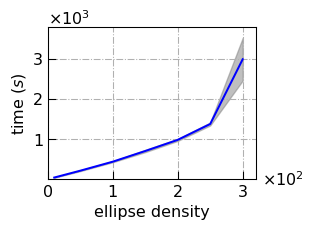

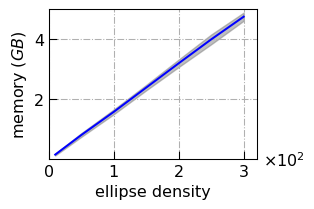

In [20]:
size = (2.93, 2.04)
dpi = 96
fig = plt.figure(figsize = size, dpi=dpi)
plt.plot(p_list, t_mean_list, color='blue', label='Line')
plt.fill_between(p_list, t_upper_list, t_lower_list, color='gray', alpha=0.5, label='std')
set_size(fig, size, dpi=dpi)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.gca().yaxis.get_offset_text().set_visible(False)
plt.text(0, 4000, r'$\times 10^3$', va='center')
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.gca().xaxis.get_offset_text().set_visible(False)
plt.text(330, 0, r'$\times 10^2$', va='center')
plt.xticks(np.arange(0, 350, 100))
plt.yticks(np.arange(1000, 4000, 1000))
plt.tick_params(direction="in", length=6)
plt.xlabel("ellipse density")
plt.ylabel("time ($s$)")
plt.xlim(0, 320)
plt.ylim(0, 3800)
plt.grid(linestyle='-.')
plt.savefig('../../docs/instance_registration_density_time.svg', format='svg')
plt.show()

size = (2.93, 2.02)
fig = plt.figure(figsize = size, dpi=dpi)
plt.plot(p_list, s_mean_list, color='blue', label='Line')
plt.fill_between(p_list, s_upper_list, s_lower_list, color='gray', alpha=0.5, label='std')
set_size(fig, size, dpi=dpi)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.gca().yaxis.get_offset_text().set_visible(False)
#plt.text(-30, 4000, r'$\times 10^3$', va='center')
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.gca().xaxis.get_offset_text().set_visible(False)
plt.text(330, 0, r'$\times 10^2$', va='center')
plt.xticks(np.arange(0, 350, 100))
plt.yticks(np.arange(2000, 5000, 2000))
plt.tick_params(direction="in", length=6)
plt.xlabel("ellipse density")
plt.ylabel("memory ($GB$)")
plt.xlim(0, 320)
plt.ylim(0, 5000)
plt.grid(linestyle='-.')
plt.savefig('../../docs/instance_registration_density_space.svg', format='svg')
plt.show()